In [1]:
%config IPCompleter.greedy = True
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from Two_Class_MNIST import TwoClassMnist as tcm

/home/alemag/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
x_train, x_test, y_train, y_test, input_shape = tcm.returnDataSet(1, 2)
dataset = ((x_train, y_train), (x_test, y_test))
RUN_NAME = "rsmsw"
num_classes = 2

x_train shape: (12700, 28, 28, 1)
12700 train samples
2167 test samples


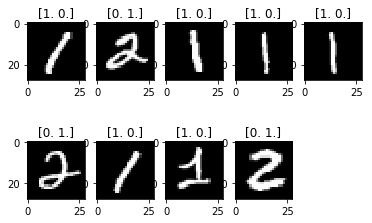

In [3]:
x_trainImage = x_train.reshape(x_train.shape[0], 28, 28)
for i in range(0, 9):
    plt.subplot(250 + (i+1))
    plt.imshow(x_trainImage[i], cmap=plt.get_cmap('gray'))
    plt.title(y_train[i])    

In [4]:
def make_model(dense_layer_sizes, filters, kernel_size, pool_size,
              optimizer, activation, dropout_rate):
    '''Creates model comprised of 2 convolutional layers followed by dense layers

    dense_layer_sizes: List of layer sizes.
        This list has one number for each layer
    filters: Number of convolutional filters in each convolutional layer
    kernel_size: Convolutional kernel size
    pool_size: Size of pooling area for max pooling
    '''

    model = Sequential()
    model.add(Conv2D(filters, kernel_size,
                     padding='valid',
                     input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(filters, kernel_size))
    model.add(Activation(activation))
    
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(dropout_rate))

    model.add(Flatten())
    for layer_size in dense_layer_sizes:
        model.add(Dense(layer_size))
        model.add(Activation(activation))
        
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    return model

In [5]:
dense_size_candidates = [[32], [64], [32, 32], [64, 64]]
#dense_size_candidates = [16, 32, 64]
my_classifier = KerasClassifier(make_model, verbose=1)

# Embed in to dictionary
param_dist = {"dense_layer_sizes": dense_size_candidates,
              "filters":[32, 64],
              "kernel_size":[3, 5],
              "pool_size": [2],              
              "optimizer": ['SGD', 'Adam', 'Adagrad'],                            
              "activation": ['sigmoid', 'relu'],              
              "dropout_rate": [0.0, 0.1, 0.2],              
              "batch_size": [32, 64, 128],
              "epochs": [5]}

In [6]:
# dense_size_candidates = [[32], [64], [32, 32], [64, 64]]
# my_classifier = KerasClassifier(make_model, batch_size=32)
# # Embed in to dictionary
# param_dist = {"batch_size": [8, 16],
#               "epochs": [1, 2],
#               "filters": [8],
#               "kernel_size": [3],
#               "pool_size": [2],
#               "dense_layer_sizes": dense_size_candidates}


In [ ]:
%%time
validator = RandomizedSearchCV(my_classifier,
                               param_distributions=param_dist,
                               scoring='neg_log_loss',
                               n_jobs=1)
history = validator.fit(x_train, y_train)

Epoch 1/5
8466/8466 [==============================] - 102s 12ms/step - loss: 0.1497 - acc: 0.9731
Epoch 2/5
8466/8466 [==============================] - 109s 13ms/step - loss: 0.0414 - acc: 0.9885
Epoch 3/5
8466/8466 [==============================] - 99s 12ms/step - loss: 0.0325 - acc: 0.9909
Epoch 4/5
8466/8466 [==============================] - 107s 13ms/step - loss: 0.0296 - acc: 0.9913
Epoch 5/5
8466/8466 [==============================] - 35s 4ms/step
Epoch 1/5
8467/8467 [==============================] - 115s 14ms/step - loss: 0.1852 - acc: 0.9709
Epoch 2/5
8467/8467 [==============================] - 125s 15ms/step - loss: 0.0413 - acc: 0.9874
Epoch 3/5
8467/8467 [==============================] - 117s 14ms/step - loss: 0.0319 - acc: 0.9902
Epoch 4/5
8467/8467 [==============================] - 105s 12ms/step - loss: 0.0281 - acc: 0.9907
Epoch 5/5
8467/8467 [==============================] - 23s 3ms/step
Epoch 1/5
8467/8467 [==============================] - 68s 8ms/step - los

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8467/8467 [==============================] - 41s 5ms/step - loss: 0.0127 - acc: 0.9962
Epoch 4/5
8467/8467 [==============================] - 41s 5ms/step - loss: 0.0077 - acc: 0.9980
Epoch 5/5
8467/8467 [==============================] - 13s 2ms/step
Epoch 1/5
8467/8467 [==============================] - 43s 5ms/step - loss: 0.0645 - acc: 0.9824
Epoch 2/5
1152/8467 [===>..........................] - ETA: 34s - loss: 0.0334 - acc: 0.9939

In [53]:
def dump(obj):
    for attr in dir(obj):
        if hasattr( obj, attr ):
            print( "obj.%s = %s" % (attr, getattr(obj, attr)))

#dump(history)

In [8]:

# validator.best_estimator_ returns sklearn-wrapped version of best model.
# validator.best_estimator_.model returns the (unwrapped) keras model

best_model = validator.best_estimator_.model
metric_names = best_model.metrics_names
metric_values = best_model.evaluate(x_test, y_test)
for metric, value in zip(metric_names, metric_values):
    print(metric, ': ', value)

2167/2167 [==============================] - 3s 2ms/step
loss :  0.0017540853339882154
acc :  0.9990770650669127


In [10]:
print(validator.best_params_)

{'pool_size': 2, 'optimizer': 'Adam', 'kernel_size': 5, 'filters': 32, 'epochs': 5, 'dropout_rate': 0.2, 'dense_layer_sizes': [64, 64], 'batch_size': 64, 'activation': 'relu'}


In [58]:
pd.DataFrame(validator.cv_results_)

/home/alemag/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/alemag/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/alemag/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/alemag/anaconda3/lib/pyth

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pool_size,param_optimizer,param_kernel_size,param_filters,param_epochs,param_dropout_rate,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,470.471976,93.883001,14.224544,4.403236,2,SGD,3,64,5,0.1,...,-0.025113,-0.019197,-0.025168,0.004897,4,-0.024299,-0.019595,-0.021429,-0.021774,0.001936
1,533.063854,2.655521,16.846290,0.240752,2,Adam,5,64,5,0.2,...,-0.118426,-0.028182,-0.070739,0.037019,7,-0.058529,-0.117512,-0.029368,-0.068469,0.036665
2,200.118264,0.744450,7.061008,0.180674,2,Adagrad,5,32,5,0,...,-0.691871,-0.030661,-0.471119,0.311433,9,-0.695088,-0.691861,-0.031004,-0.472651,0.312295
3,337.031803,1.585431,10.980747,0.033871,2,SGD,3,64,5,0.2,...,-0.027722,-0.025817,-0.025789,0.001590,5,-0.019465,-0.020392,-0.027402,-0.022420,0.003543
4,203.532809,0.664901,7.169062,0.067897,2,SGD,5,32,5,0.2,...,-0.306106,-0.678116,-0.507321,0.153382,10,-0.524915,-0.306229,-0.675626,-0.502257,0.151655
5,335.422163,0.360173,11.240092,0.043561,2,SGD,3,64,5,0.2,...,-0.374080,-0.688486,-0.436188,0.185892,8,-0.228859,-0.374354,-0.687327,-0.430180,0.191286
6,316.580574,0.746950,10.663084,0.131800,2,Adagrad,3,64,5,0,...,-0.029941,-0.011068,-0.017305,0.008935,3,-0.002638,-0.007613,-0.005967,-0.005406,0.002069
7,542.170772,3.227900,17.632286,0.299681,2,SGD,5,64,5,0.1,...,-0.033182,-0.024575,-0.029783,0.003740,6,-0.029344,-0.026071,-0.029163,-0.028193,0.001502
8,318.430362,0.275863,10.608406,0.024386,2,Adam,3,64,5,0,...,-0.020548,-0.009108,-0.012969,0.005359,2,-0.001343,-0.004202,-0.002661,-0.002735,0.001169
9,208.381651,0.425404,7.458671,0.048593,2,Adam,5,32,5,0.2,...,-0.011453,-0.005236,-0.010817,0.004320,1,-0.010289,-0.002952,-0.003426,-0.005556,0.003353


/home/alemag/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/alemag/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/alemag/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/alemag/anaconda3/lib/pyth

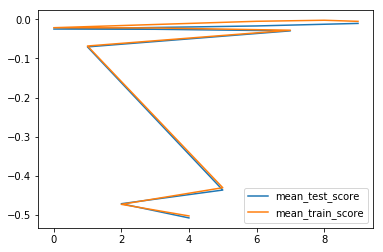

In [56]:
import pandas as pd
score = pd.DataFrame(validator.cv_results_).sort_values(by='mean_test_score', ascending = False)
score[['mean_test_score','mean_train_score']].plot()

In [59]:
# I took each epchos result manually using regex
loss = [0.1497,0.0414,0.0325,0.0296,0.0253,0.1852,0.0413,0.0319,0.0281,0.0251,0.1660,0.0354,0.0284,0.0248,0.9697,0.3399,0.1563,0.1027,0.0771,0.8033,0.5304,0.3330,0.2377,0.1726,0.4928,0.1194,0.0715,0.0410,0.6956,0.6927,0.6923,0.6926,0.6923,0.6939,0.6920,0.6917,0.6916,0.6918,0.6929,0.6907,0.2833,0.0584,0.0386,0.2494,0.0468,0.0355,0.0274,0.2358,0.0539,0.0405,0.0390,0.0345,0.2423,0.0519,0.0427,0.0352,0.0320,0.7156,0.6952,0.6855,0.6670,0.0418,0.0377,0.0337,0.2887,0.0635,0.0483,0.0401,0.0368,0.0588,0.0219,0.0121,0.0054,0.0026,0.0613,0.0141,0.0092,0.0059,0.0028,0.0601,0.0206,0.0138,0.0083,0.0022,]
accuracy = [0.9731,0.9885,0.9909,0.9913,0.9924,0.9709,0.9874,0.9902,0.9907,0.9922,0.9675,0.9906,0.9916,0.9933,0.5237,0.8824,0.9815,0.9862,0.9888,0.5218,0.7337,0.9218,0.9615,0.9785,0.7764,0.9871,0.9898,0.9928,0.5152,0.5209,0.5223,0.5200,0.5207,0.5214,0.5257,0.5309,0.5266,0.5309,0.5271,0.5350,0.8831,0.9910,0.9933,0.9533,0.9880,0.9901,0.9918,0.9447,0.9846,0.9888,0.9885,0.9908,0.9464,0.9856,0.9884,0.9900,0.9910,0.5024,0.5245,0.5530,0.6003,0.9872,0.9880,0.9895,0.9316,0.9835,0.9852,0.9880,0.9890,0.9828,0.9933,0.9961,0.9981,0.9987,0.9831,0.9949,0.9968,0.9980,0.9992,0.9799,0.9953,0.9961,0.9982,0.9995]

df = pd.DataFrame({'loss':loss, 'acc':accuracy})
df.head()

,loss,acc
0,0.1497,0.9731
1,0.0414,0.9885
2,0.0325,0.9909
3,0.0296,0.9913
4,0.0253,0.9924


Text(0,0.5,'Loss/Acc')

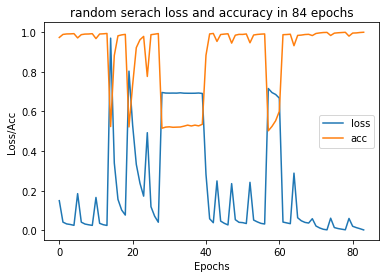

In [62]:
epochs = range(0,85)
img = df.plot(title='random serach loss and accuracy in 84 epochs')
img.set_xlabel("Epochs")
img.set_ylabel("Loss/Acc")
